In [31]:
# import libraries

# basic

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing, model selection and scores

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report,\
                            roc_auc_score
from xgboost import XGBClassifier

# nlp

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

%matplotlib inline

In [3]:
# read in data

from google.colab import drive 
drive.mount('/content/gdrive')

df = pd.read_csv('gdrive/My Drive/labeled.csv')

Mounted at /content/gdrive


In [4]:
# check the data

print(df.shape)
df.head()

(102037, 13)


,subreddit,author,date,post,covid_related,suicidal,alc_abuse,loneliness,stress,n_words,n_sentences,lemmatized,label
0,alcoholism,glorybellpirate,2020-01-01,Day 1 of sobriety Feeling anxious and letting ...,0,0,1,0,0,24,3,day 1 of sobriety feel anxious and let the fee...,0
1,alcoholism,EhndlessSl0th,2020-01-01,"Started the New Year with a bang. Hey, I'm new...",0,1,1,0,1,577,41,start the new year with a bang hey -pron- be n...,0
2,alcoholism,the_kinky_penguin,2020-01-01,Why can't I get drunk anymore I've been a heav...,0,0,1,0,0,64,5,why ca not -pron- get drunk anymore -pron- hav...,0
3,alcoholism,SauceoffSauceOn,2020-01-01,I am an Alcoholic. How do I quit? I have been ...,0,0,1,0,1,111,14,-pron- be an alcoholic how do -pron- quit -pro...,0
4,alcoholism,ben42187,2020-01-01,Funniest Thing about Alcoholism With every oth...,0,0,1,0,0,136,0,funniest thing about alcoholism with every oth...,0


## Text Preprocessing and Bootstrapping

In [5]:
# update stop_words for TF-IDF vectorizer

remove = ['-pron-', 'feel', 'know', 'want', 'life', 'go', 'think', 'make', 'people', 'really', 'even', 'much', 'now', 
          'pron', 'don', 'will', 'try', 'talk', 'friends', 'tell', 'just', 'like', 'time', 'want', 'well', 'thing', 'day',
          'friend', 'help', 'year', 'bad', 've', 'say', 'good', 'need', 'way', 'right', 'month', 'amp', 'x200b']

my_stop_words = text.ENGLISH_STOP_WORDS.union(remove)

In [6]:
# instantiate Tf-IDF

tvec = TfidfVectorizer(stop_words = my_stop_words, max_df = .80, min_df = 10, max_features = 256, ngram_range = (1, 1))

In [7]:
# import resample library for bootstrapping

from sklearn.utils import resample

# prepare bootstrap sample

boot = resample(df, replace = True, random_state = 2020, stratify = df['label'])

# check bootstrapped data

boot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102037 entries, 92288 to 47793
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   subreddit      102037 non-null  object
 1   author         102037 non-null  object
 2   date           102037 non-null  object
 3   post           102037 non-null  object
 4   covid_related  102037 non-null  int64 
 5   suicidal       102037 non-null  int64 
 6   alc_abuse      102037 non-null  int64 
 7   loneliness     102037 non-null  int64 
 8   stress         102037 non-null  int64 
 9   n_words        102037 non-null  int64 
 10  n_sentences    102037 non-null  int64 
 11  lemmatized     102037 non-null  object
 12  label          102037 non-null  int64 
dtypes: int64(8), object(5)
memory usage: 10.9+ MB


In [8]:
# set X and y

X = boot['lemmatized']
y = boot['label']

In [9]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 2020)

In [10]:
# fit/transform X then save it to a dataframe

train = tvec.fit_transform(X_train).toarray()
print(train.shape)

test = tvec.transform(X_test).toarray()
print(test.shape)

(71425, 256)
(30612, 256)


## XGBoost

In [17]:
# instantiate the model and fit

xgb = XGBClassifier(random_state = 2020)
xgb.fit(train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2020,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [18]:
# cross validate

print(f'Train CV Score: {cross_val_score(xgb, train, y_train, cv = 3).mean()}')
print(f'Test CV Score: {cross_val_score(xgb, test, y_test, cv = 3).mean()}')

Train CV Score: 0.8157367844149023
Test CV Score: 0.8149091859401542


### GridSearch

In [19]:
# set tuning parameters for gridsearch

params = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
          'max_depth': [3, 5, 7, 9]}

# instantiate gridsearch

gs = GridSearchCV(xgb, param_grid = params, cv = 3)

In [20]:
# fit

gs.fit(train, y_train)

# get best score and parameters

print(f'Best Score: {gs.best_score_}')
print(f'Best Parameters: {gs.best_params_}')

Best Score: 0.8669233735574978
Best Parameters: {'learning_rate': 0.5, 'max_depth': 9}


In [22]:
# gridsearch again, since it picked the highest of the given values

# new parameters

params = {'learning_rate': [0.5, 0.7, 0.9],
          'max_depth': [9, 11, 13]}

# instantiate gridsearch again

gs = GridSearchCV(xgb, param_grid = params, cv = 3)

# fit

gs.fit(train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=2020, reg_alpha=0,
                                     reg_lambda=1, scale_pos_weight=1,
                                     seed=None, silent=None, subsample=1,
                                     verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.5, 0.7, 0.9],
                         'max_depth': [9, 11, 13]},
             pre_dispatch=

In [23]:
# get best score and parameters

print(f'Best Score: {gs.best_score_}')
print(f'Best Parameters: {gs.best_params_}')

Best Score: 0.8815680826698618
Best Parameters: {'learning_rate': 0.7, 'max_depth': 13}


In [24]:
# try a few more max_depth

params = {'learning_rate': [0.7],
          'max_depth': [13, 15, 17]}

# instantiate GridSearch and fit

gs = GridSearchCV(xgb, param_grid = params, cv = 3)
gs.fit(train, y_train)

# get the best score and parameters

print(f'Best Score: {gs.best_score_}')
print(f'Best Parameters: {gs.best_params_}')

Best Score: 0.8867903551539426
Best Parameters: {'learning_rate': 0.7, 'max_depth': 17}


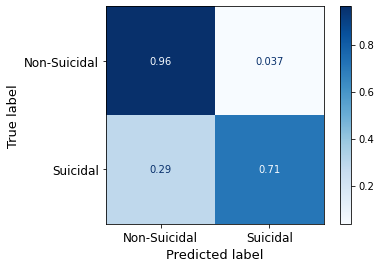

In [26]:
# predictions

test_pred = gs.predict(test)

# confusion matrix values

tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()

# plot confusion matrix

labels = ['Non-Suicidal', 'Suicidal']

plot_confusion_matrix(gs, test, y_test, cmap = 'Blues', normalize = 'true')
plt.xticks(ticks = [0, 1], labels = labels, size = 12)
plt.yticks(ticks = [0, 1], labels = labels, size = 12)
plt.xlabel('Predicted label', size = 13)
plt.ylabel('True label', size = 13);

In [27]:
# classification report

print(classification_report(y_test, test_pred, target_names = labels))

              precision    recall  f1-score   support

Non-Suicidal       0.93      0.96      0.95     24327
    Suicidal       0.83      0.71      0.77      6285

    accuracy                           0.91     30612
   macro avg       0.88      0.84      0.86     30612
weighted avg       0.91      0.91      0.91     30612



### ROC-AUC Score

In [29]:
# create a dataframe with just labels (true/predicted)

pred_proba = [i[1] for i in gs.predict_proba(test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

In [32]:
# get roc-auc score

roc_auc_score(y_test, pred_proba)

0.9216957799098919

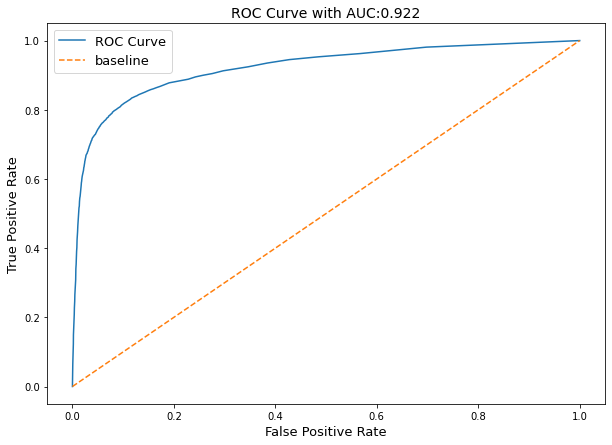

In [36]:
# create figure

plt.figure(figsize = (10,7))

# create threshold values (dashed orange line)

thresholds = np.linspace(0, 1, 200)

# define function to calculate sensitivity (true positive rate)

def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# define function to calculate false positive rate (1 - specificity)

def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# calculate sensitivity & 1-specificity for each threshold between 0 and 1

tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# plot roc curve

plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label = 'ROC Curve')

# plot baseline

plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label = 'baseline',
         linestyle = '--')

# label axes

plt.title('ROC Curve with AUC:' + round(roc_auc_score(pred_df['true_values'], pred_df['pred_probs']), 3).astype(str), fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 13)
plt.xlabel('False Positive Rate', fontsize = 13)

# legend

plt.legend(fontsize = 13);